In [1]:
import requests
import zipfile
import os

output_dir = "../data"
os.makedirs(output_dir, exist_ok=True)  

url = "https://s3.amazonaws.com/keras-datasets/jena_climate_2009_2016.csv.zip"

zip_path = os.path.join(output_dir, "jena_climate_2009_2016.csv.zip")

response = requests.get(url, stream=True)
if response.status_code == 200:
    with open(zip_path, "wb") as file:
        for chunk in response.iter_content(chunk_size=8192):
            file.write(chunk)
    print(f"File saved in: {zip_path}")
else:
    print(f"code status: {response.status_code}")

with zipfile.ZipFile(zip_path, "r") as zip_ref:
    zip_ref.extractall(output_dir)  
    print(f"Files extracted in: {output_dir}")

csv_path = os.path.join(output_dir, "jena_climate_2009_2016.csv")
if os.path.exists(csv_path):
    print(f"CSV file found in: {csv_path}")
else:
    print("Error")

File saved in: ../data\jena_climate_2009_2016.csv.zip
Files extracted in: ../data
CSV file found in: ../data\jena_climate_2009_2016.csv


In [2]:
with open(csv_path) as f:
    data = f.read()

lines = data.split('\n')
header = lines[0].split(',')
lines = lines[1:]
print(header)
print(len(lines))

['"Date Time"', '"p (mbar)"', '"T (degC)"', '"Tpot (K)"', '"Tdew (degC)"', '"rh (%)"', '"VPmax (mbar)"', '"VPact (mbar)"', '"VPdef (mbar)"', '"sh (g/kg)"', '"H2OC (mmol/mol)"', '"rho (g/m**3)"', '"wv (m/s)"', '"max. wv (m/s)"', '"wd (deg)"']
420451


In [3]:
import numpy as np
temperature = np.zeros((len(lines),))
raw_data = np.zeros((len(lines), len(header) - 1))
for i, line in enumerate(lines):
    values = [float(x) for x in line.split(',')[1:]]
    temperature[i] = values[1]
    raw_data[i, :] = values[:]

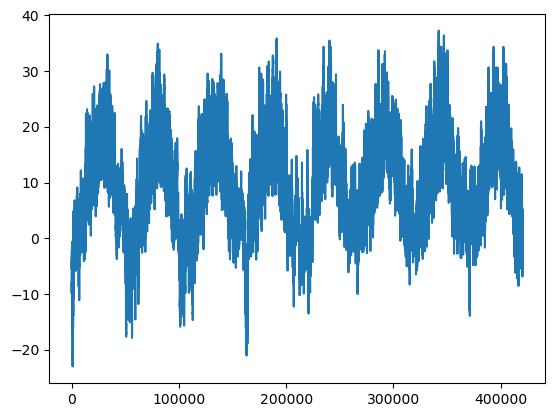

In [4]:
from matplotlib import pyplot as plt 
plt.plot(range(len(temperature)), temperature)
plt.show()

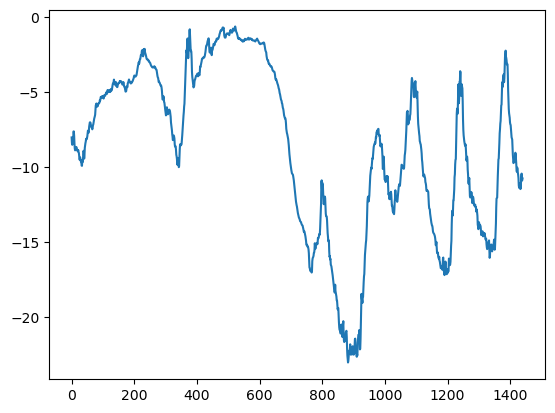

In [5]:
plt.plot(range(1440), temperature[:1440])
plt.show()

In [6]:
num_train_samples = int(0.5*len(raw_data))
num_val_samples = int(0.25*len(raw_data))
num_test_samples = len(raw_data) - num_train_samples - num_val_samples
print('num_train_samples: ', num_train_samples)
print('num_val_samples: ', num_val_samples)
print('num_test_samples: ', num_test_samples)

num_train_samples:  210225
num_val_samples:  105112
num_test_samples:  105114


In [7]:
#Normalizing the data
mean = raw_data[:num_train_samples].mean(axis=0)
raw_data -= mean
std = raw_data[:num_train_samples].std(axis=0)
raw_data /= std

In [8]:
from tensorflow import keras
sampling_rate = 6
sequence_length = 120
delay = sampling_rate * (sequence_length+24-1)
batch_size =256

train_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=0,
    end_index=num_train_samples)

val_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples,
    end_index=num_train_samples + num_val_samples)

test_dataset = keras.utils.timeseries_dataset_from_array(
    raw_data[:-delay],
    targets=temperature[delay:],
    sampling_rate=sampling_rate,
    sequence_length=sequence_length,
    shuffle=True,
    batch_size=batch_size,
    start_index=num_train_samples + num_val_samples)

In [9]:
for samples, targets in train_dataset:
    print("samples shape:", samples.shape)
    print("targets shape:", targets.shape)
    break

samples shape: (256, 120, 14)
targets shape: (256,)


In [10]:
#comon sense baseline MAE
def evaluate_naive_method(dataset):
    total_abs_err = 0.
    samples_seen = 0
    for samples, targets in dataset:
        preds = samples[:, -1, 1] * std[1] + mean[1]
        total_abs_err += np.sum(np.abs(preds - targets))
        samples_seen += samples.shape[0]
    return total_abs_err / samples_seen
print(f"Validation MAE: {evaluate_naive_method(val_dataset):.2f}")
print(f"Test MAE: {evaluate_naive_method(test_dataset):.2f}")

Validation MAE: 2.44
Test MAE: 2.62


In [11]:
raw_data.shape[-1]

14

In [12]:
from tensorflow.keras import layers

inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Flatten()(inputs)
x = layers.Dense(16, activation='relu')(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)

callbacks = [
    keras.callbacks.ModelCheckpoint('jena_dense.keras',
                                    save_best_only = True)
]
model.compile(optimizer='rmsprop', loss='mse',metrics=['mae'])
history = model.fit(train_dataset,
                    epochs = 10, 
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model('jena_dense.keras')
print(f'Test MAE: {model.evaluate(test_dataset)[1]:.2f}')

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 6s 6ms/step - loss: 23.3298 - mae: 3.5931 - val_loss: 13.6187 - val_mae: 2.8912
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 11.9718 - mae: 2.7364 - val_loss: 12.7622 - val_mae: 2.8296
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 10.9925 - mae: 2.6189 - val_loss: 13.2926 - val_mae: 2.8639
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 10.3500 - mae: 2.5376 - val_loss: 12.1461 - val_mae: 2.7418
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 9.8200 - mae: 2.4732 - val_loss: 16.5143 - val_mae: 3.2379
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 9.3089 - mae: 2.4083 - val_loss: 11.0880 - val_mae: 2.6214
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 8.8989 - mae: 2.3570 - val_loss: 13.9050 - val_mae: 2.9566
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 6s 7ms/step - loss: 8.6269 - mae: 2.3182 - val_loss: 11.2245 - val_mae: 2.6479
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 6s 7

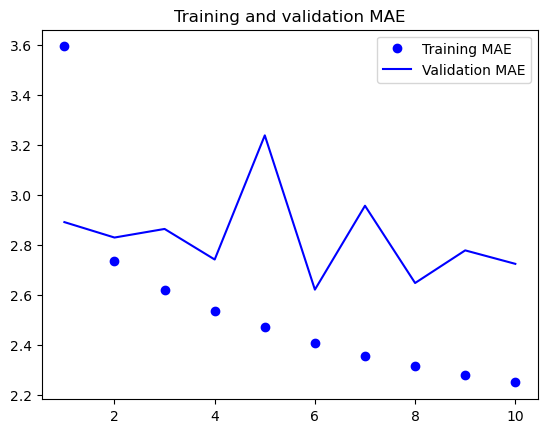

In [13]:
import matplotlib.pyplot as plt
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, "bo", label="Training MAE")
plt.plot(epochs, val_loss, "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [14]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Conv1D(8, 24, activation='relu')(inputs)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 12, activation='relu')(x)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(8, 6, activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs) 

callbacks = [keras.callbacks.ModelCheckpoint('jena_conv.keras',
                                            save_best_only=True)]
model.compile(optimizer='rmsprop', loss='mse', metrics=['mae'])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data = val_dataset,
                    callbacks=callbacks)

model = keras.models.load_model('jena_conv.keras')
print(f'Test MAE: {model.evaluate(test_dataset)[1]:.2f}')

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 10s 11ms/step - loss: 22.4253 - mae: 3.6900 - val_loss: 16.2652 - val_mae: 3.2106
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 9s 11ms/step - loss: 15.3575 - mae: 3.1120 - val_loss: 15.6786 - val_mae: 3.1357
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 14.2071 - mae: 2.9907 - val_loss: 17.8464 - val_mae: 3.3326
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 13.5106 - mae: 2.9152 - val_loss: 15.3744 - val_mae: 3.1051
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 12.9414 - mae: 2.8506 - val_loss: 15.9063 - val_mae: 3.1323
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 12.4315 - mae: 2.7966 - val_loss: 16.6326 - val_mae: 3.2604
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 12.0075 - mae: 2.7486 - val_loss: 18.7506 - val_mae: 3.4335
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 8s 10ms/step - loss: 11.6427 - mae: 2.7027 - val_loss: 15.1481 - val_mae: 3.0944
Epoch 9/10
819/819 ━━━━━━━━━━━━

In [17]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(16)(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
    keras.callbacks.ModelCheckpoint("jena_lstm.keras",
                                    save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
    epochs=10,
    validation_data=val_dataset,
    callbacks=callbacks)
model = keras.models.load_model("jena_lstm.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

Epoch 1/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 26s 30ms/step - loss: 42.6741 - mae: 4.7685 - val_loss: 12.6061 - val_mae: 2.6924
Epoch 2/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 25s 30ms/step - loss: 11.1478 - mae: 2.5926 - val_loss: 9.7279 - val_mae: 2.4257
Epoch 3/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - loss: 9.8711 - mae: 2.4491 - val_loss: 10.0662 - val_mae: 2.4559
Epoch 4/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - loss: 9.3735 - mae: 2.3907 - val_loss: 9.5952 - val_mae: 2.3919
Epoch 5/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - loss: 8.9874 - mae: 2.3419 - val_loss: 9.6216 - val_mae: 2.4162
Epoch 6/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 28s 33ms/step - loss: 8.7938 - mae: 2.3143 - val_loss: 9.7565 - val_mae: 2.4226
Epoch 7/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - loss: 8.6135 - mae: 2.2882 - val_loss: 10.0039 - val_mae: 2.4468
Epoch 8/10
819/819 ━━━━━━━━━━━━━━━━━━━━ 28s 34ms/step - loss: 8.4697 - mae: 2.2686 - val_loss: 10.1512 - val_mae: 2.4645
Epoch 9/10
819/819 ━━━━━━━━━━━━━━━

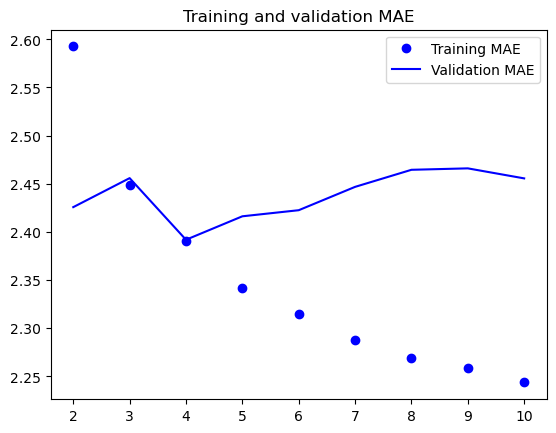

In [20]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(2, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss[1:], "bo", label="Training MAE")
plt.plot(epochs, val_loss[1:], "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [24]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.LSTM(32, recurrent_dropout=0.25)(inputs)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint("jena_lstm_dropout.keras",
 save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
 epochs=50,
 validation_data=val_dataset,
 callbacks=callbacks) 

Epoch 1/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 116s 139ms/step - loss: 26.6933 - mae: 3.8305 - val_loss: 9.5214 - val_mae: 2.3947
Epoch 2/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 111s 135ms/step - loss: 14.9771 - mae: 3.0070 - val_loss: 9.2854 - val_mae: 2.3742
Epoch 3/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 110s 134ms/step - loss: 14.2740 - mae: 2.9321 - val_loss: 9.0889 - val_mae: 2.3417
Epoch 4/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 109s 133ms/step - loss: 13.8136 - mae: 2.8835 - val_loss: 9.0540 - val_mae: 2.3331
Epoch 5/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 115s 140ms/step - loss: 13.3283 - mae: 2.8339 - val_loss: 9.0957 - val_mae: 2.3402
Epoch 6/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 120s 146ms/step - loss: 12.9434 - mae: 2.7883 - val_loss: 8.9567 - val_mae: 2.3156
Epoch 7/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 111s 136ms/step - loss: 12.7059 - mae: 2.7659 - val_loss: 8.9568 - val_mae: 2.3180
Epoch 8/50
819/819 ━━━━━━━━━━━━━━━━━━━━ 114s 139ms/step - loss: 12.3768 - mae: 2.7302 - val_loss: 8.8942 - val_mae: 2.3101
Epoch 9/50
819/8

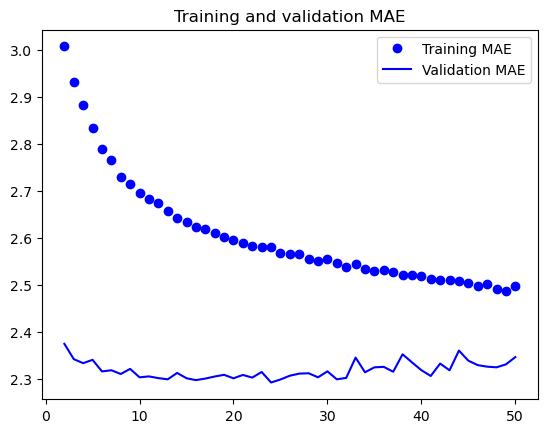

In [25]:
loss = history.history["mae"]
val_loss = history.history["val_mae"]
epochs = range(2, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss[1:], "bo", label="Training MAE")
plt.plot(epochs, val_loss[1:], "b", label="Validation MAE")
plt.title("Training and validation MAE")
plt.legend()
plt.show()

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.GRU(32, recurrent_dropout=0.5, return_sequences=True)(inputs)
x = layers.GRU(32, recurrent_dropout=0.5)(x)
x = layers.Dropout(0.5)(x)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
callbacks = [
 keras.callbacks.ModelCheckpoint("jena_stacked_gru_dropout.keras",
 save_best_only=True)
]
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=50,
                    validation_data=val_dataset,
                    callbacks=callbacks)
model = keras.models.load_model("jena_stacked_gru_dropout.keras")
print(f"Test MAE: {model.evaluate(test_dataset)[1]:.2f}")

In [ ]:
inputs = keras.Input(shape=(sequence_length, raw_data.shape[-1]))
x = layers.Bidirectional(layers.LSTM(16))(inputs)
outputs = layers.Dense(1)(x)
model = keras.Model(inputs, outputs)
model.compile(optimizer="rmsprop", loss="mse", metrics=["mae"])
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=val_dataset)